## Apply Learning Rate Schedulers with Optimizers

In [1]:
import torch 
import torch.nn as nn
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exponential learning rate from Lambda function

In [2]:
start_lr = 1e-3
end_lr = 1e-1
n_epochs = 5
n_batches = 10
# total number of iteration
n_iter = n_epochs * n_batches 
lr_lambda = lambda x: start_lr*math.exp( x * math.log(end_lr / start_lr) / (n_epochs * n_batches))

In [3]:
lr_list = [lr_lambda(i) for i in range(n_iter)]

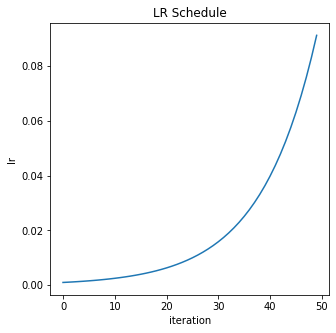

In [5]:
_, ax = plt.subplots(1, 1, figsize=(5, 5)) # Note: ax is a list with 2 or more subplots
ax.set_title('LR Schedule')
ax.set_ylabel('lr')
ax.set_xlabel('iteration')
xi = list(range(len(lr_list)))
ax.plot(xi, lr_list)
plt.show()

## Pytorch: Combine learning rate scheduler with an optimizer

## 1. LambdaLR scheduler
- Sets the learning rate of each parameter group to the initial lr times a given function. When last_epoch=-1, sets initial lr as lr.

In [6]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 =  nn.Linear(5, 10)
        self.fc2 =  nn.Linear(10, 2) 
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out

In [8]:
start_lr = 1e-2
end_lr = 3e-1
n_epochs = 5
n_batches = 10
# total number of iteration
n_iter = n_epochs * n_batches 
# user-define learning rate components:
# lamda scheduler and optimizer
lr_lambda = lambda x: start_lr*math.exp( x * math.log(end_lr / start_lr) / (n_epochs * n_batches))
model = DNN()
optimizer = torch.optim.SGD(model.parameters(), 0.01) ## base_lr = 0.01
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

lr_list = []
lr_list2 = []
for i in range(n_epochs):
    print(f"--epoch: {i}--")
    for j in range(n_batches):
        ## current learning rate for optimizer
        lr = optimizer.state_dict()["param_groups"][0]["lr"]  
        #lr2 =scheduler.get_last_lr()         
        optimizer.step()   
        scheduler.step()
        lr_list.append(lr)   

--epoch: 0--
--epoch: 1--
--epoch: 2--
--epoch: 3--
--epoch: 4--


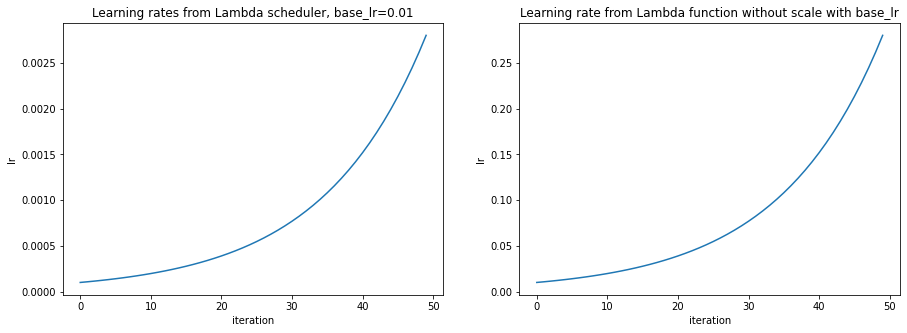

In [9]:
_, ax = plt.subplots(1, 2, figsize=(15, 5)) # Note: ax is a list with 2 or more subplots
ax[0].set_title(f'Learning rates from Lambda scheduler, base_lr={0.01}')
ax[0].set_ylabel('lr')
ax[0].set_xlabel('iteration')
xi = list(range(len(lr_list)))
ax[0].plot(xi, lr_list)

ax[1].set_title('Learning rate from Lambda function without scale with base_lr')
ax[1].set_ylabel('lr')
ax[1].set_xlabel('iteration')
lr_list2 = [lr_lambda(iter) for iter in  range(n_epochs * n_batches)]
xi = list(range(len(lr_list2)))
ax[1].plot(xi, lr_list2)
plt.show()

## 2. Cosine annealing scheduler
- initial learning rate in optimizer is the largest learning rate for the schedulr

In [11]:
start_lr = 1e-3
end_lr = 1e-1
n_epochs = 5
n_batches = 10
# total number of iteration
n_iter = n_epochs * n_batches 
# user-define learning rate components:
# lamda scheduler and optimizer
#lr_lambda = lambda x: start_lr*math.exp( x * math.log(end_lr / start_lr) / (n_epochs * n_batches))
optimizer = torch.optim.SGD(model.parameters(), end_lr) ## the largest learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max= n_iter, eta_min=start_lr)
model = DNN()
lr_list = []
lr_list2 = []
for i in range(n_epochs):
    print(f"--epoch: {i}--")
    for j in range(n_batches):
        ## current learning rate for optimizer
        lr = optimizer.state_dict()["param_groups"][0]["lr"]  
        lr2 =scheduler.get_last_lr() 
        #print(f"batch:{j}, lr:{lr}")
        optimizer.step()   
        scheduler.step()
        lr_list.append(lr)
        lr_list2.append(lr2)         

--epoch: 0--
--epoch: 1--
--epoch: 2--
--epoch: 3--
--epoch: 4--


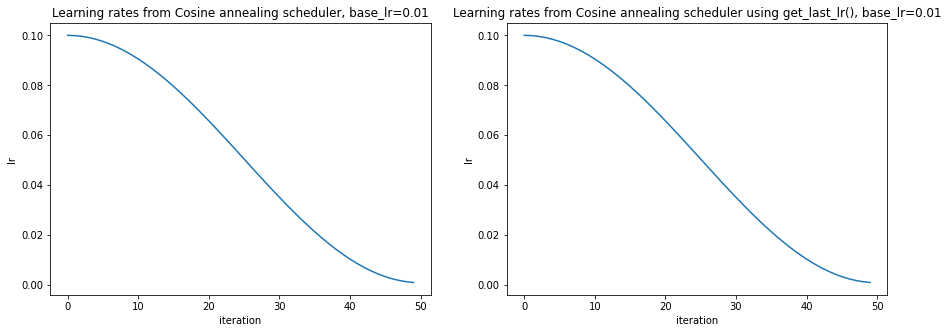

In [14]:
_, ax = plt.subplots(1, 2, figsize=(15, 5)) # Note: ax is a list with 2 or more subplots
ax[0].set_title(f'Learning rates from Cosine annealing scheduler, base_lr={0.01}')
ax[0].set_ylabel('lr')
ax[0].set_xlabel('iteration')
xi = list(range(len(lr_list)))
ax[0].plot(xi, lr_list)

ax[1].set_title(f'Learning rates from Cosine annealing scheduler using get_last_lr(), base_lr={0.01}')
ax[1].set_ylabel('lr')
ax[1].set_xlabel('iteration')
xi = list(range(len(lr_list2)))
ax[1].plot(xi, lr_list2)

plt.show()

## 3. User-defined one-cycle cosine annealing learning rate scheduler

In [16]:
def cosine_annealing(it, n_iter, start_val, end_val):
    cos_inner = math.pi * (it % n_iter) / n_iter
    return ((start_val - end_val) * (math.cos(cos_inner) + 1) / 2) + end_val


def cosine_annealing_range(n_iter, start_val, end_val):
    print(f"annealing_rang:start_val:{start_val} end_val:{end_val}")
    return [cosine_annealing(i, n_iter, start_val, end_val) 
            for i in range(n_iter)]

from torch.optim.lr_scheduler import LambdaLR
class OneCycleLR(LambdaLR):
    def __init__(self, optimizer, lr_div_factor=25, warmup_frac=0.3, 
                 n_epochs=10, n_batches=None, 
                 start_epoch=0):
        n_batches = 1 if n_batches is None else n_batches
        self.n_epochs, self.n_iter = n_epochs, (n_epochs * n_batches) + 1
        self.start_it = -1 if start_epoch==0 else start_epoch * n_batches
        ## one-cycle cosine annealing learning rate for each iteration
        n_warmup = int(self.n_iter * warmup_frac)
        n_decay = self.n_iter - n_warmup        
        self.lrs = cosine_annealing_range(n_warmup, 1/lr_div_factor, 1)
        self.lrs += cosine_annealing_range(n_decay, 1, 1/lr_div_factor)
        #print(self.lrs)
        ## create lambda function from the learning rate list
        self.lr_lambda = lambda i: self.lrs[i]        
        super().__init__(optimizer, self.lr_lambda, last_epoch=self.start_it)
    def step(self, epoch=None):
        super().step(epoch)        



In [17]:
scheduler = OneCycleLR(optimizer,lr_div_factor=25, warmup_frac=0.3, n_epochs=5, n_batches=10 )
print(f"length of learning rates:{len(scheduler.lrs)}, \n learning rates:\n{scheduler.lrs}")

annealing_rang:start_val:0.04 end_val:1
annealing_rang:start_val:1 end_val:0.04
length of learning rates:51, 
 learning rates:
[0.040000000000000036, 0.050489151647773345, 0.08149818033155165, 0.1316718427000253, 0.19881730894774807, 0.28, 0.3716718427000253, 0.46982633763152637, 0.5701736623684737, 0.6683281572999747, 0.7599999999999999, 0.8411826910522517, 0.9083281572999747, 0.9585018196684485, 0.9895108483522267, 1.0, 0.9981734550840379, 0.99270772144586, 0.9836443966187527, 0.971052457977236, 0.955027737777592, 0.9356921938165307, 0.9131929812587162, 0.8877013326971094, 0.8594112549695427, 0.8285380526495388, 0.7953166894485021, 0.76, 0.7228567656355358, 0.6841696687963211, 0.6442331416492101, 0.6033511252801267, 0.5618347565188759, 0.52, 0.4781652434811241, 0.4366488747198734, 0.39576685835078995, 0.35583033120367913, 0.31714323436446434, 0.2800000000000001, 0.24468331055149783, 0.21146194735046112, 0.18058874503045722, 0.1522986673028906, 0.1268070187412839, 0.10430780618346952,

In [21]:
start_lr = 1e-3
end_lr = 1e-1
n_epochs = 5
n_batches = 10
# total number of iteration
n_iter = n_epochs * n_batches 
# user-define learning rate components:
# lamda scheduler and optimizer
optimizer = torch.optim.SGD(model.parameters(), end_lr) ## the largest learning rate
scheduler = OneCycleLR(optimizer,lr_div_factor=25, warmup_frac=0.3, n_epochs=n_epochs, n_batches=n_batches )

model = DNN()
lr_list = []
for i in range(n_epochs):
    print(f"--epoch: {i}--")
    for j in range(n_batches):
        ## current learning rate for optimizer
        lr = optimizer.state_dict()["param_groups"][0]["lr"]  
        optimizer.step()   
        scheduler.step()
        lr_list.append(lr)
        

annealing_rang:start_val:0.04 end_val:1
annealing_rang:start_val:1 end_val:0.04
--epoch: 0--
--epoch: 1--
--epoch: 2--
--epoch: 3--
--epoch: 4--


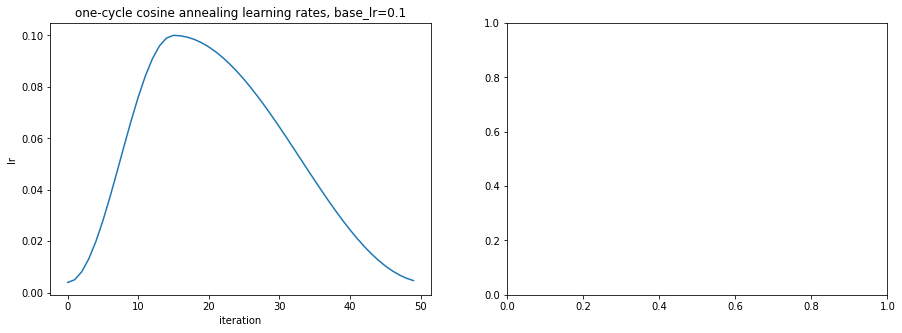

In [22]:
_, ax = plt.subplots(1, 2, figsize=(15, 5)) # Note: ax is a list with 2 or more subplots
ax[0].set_title(f'one-cycle cosine annealing learning rates, base_lr={end_lr}')
ax[0].set_ylabel('lr')
ax[0].set_xlabel('iteration')
xi = list(range(len(lr_list)))
ax[0].plot(xi, lr_list)

plt.show()